In [1]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from scipy import special
from tensorflow.keras import layers
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
M = 16
k = int(np.log2(M))
n = 1
TRAINING_SNR = 7
rayleigh = True

In [3]:
def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(k/n)*ebno) 
    return noise_std

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

In [4]:
# From https://colab.research.google.com/github/google-research/google-research/blob/master/vbmi/vbmi_demo.ipynb#scrollTo=LwSIGeXlD11E
# concatenated critic

class NN_function(tf.keras.Model):
    def __init__(self, hidden_dim, layers, activation, **extra_kwargs):
        super(NN_function, self).__init__()
        self._f = tf.keras.Sequential(
          [tf.keras.layers.Dense(hidden_dim, activation) for _ in range(layers)] +
          [tf.keras.layers.Dense(1)])

    def call(self, x, y):
        batch_size = tf.shape(x)[0]
        x_tiled = tf.tile(x[None, :],  (batch_size, 1, 1))
        y_tiled = tf.tile(y[:, None],  (1, batch_size, 1))
        xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size * batch_size, -1])
        scores = self._f(xy_pairs)
        return tf.transpose(tf.reshape(scores, [batch_size, batch_size]))

In [5]:
critic_params = {
    'layers': 2,
    'hidden_dim': 256,
    'activation': 'relu',
}

def MINE(scores):  
    def marg(x):
        batch_size = x.shape[0]
        marg_ = tf.reduce_mean(tf.exp(x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size))))
        return marg_*((batch_size*batch_size)/(batch_size*(batch_size-1.)))
    joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
    marg_term = marg(scores)
    return joint_term - tf.math.log(marg_term)

In [6]:
noise_std = EbNo_to_noise(TRAINING_SNR)
# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2*n]))
channel_layer = keras.layers.Lambda(lambda x: 
                    x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))
def sample_Rayleigh_channel(x, noise_std):
    h_sample = (1/np.sqrt(2))*tf.sqrt(tf.random.normal(tf.shape(x))**2+tf.random.normal(tf.shape(x))**2)
    z_sample = tf.random.normal(tf.shape(x), stddev = noise_std)
    y_sample = x + tf.divide(z_sample,h_sample)
    return tf.cast(y_sample, tf.float32)

rayleigh_channel_layer = keras.layers.Lambda(lambda x: sample_Rayleigh_channel(x,noise_std))


encoder = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal', input_length=1),
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(2*n, activation=None),
            shape_layer,
            norm_layer])
if rayleigh:
    channel = keras.models.Sequential([rayleigh_channel_layer])
else:
    channel = keras.models.Sequential([channel_layer])

decoder = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=[2,n]),
                shape_layer2,
                keras.layers.Dense(M, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])

autoencoder = keras.models.Sequential([encoder, channel, decoder])

In [7]:
def B_Ber_m(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    batch_size = input_msg.shape[0]
    pred_error = tf.not_equal(tf.reshape(input_msg, shape=(-1,batch_size)), tf.argmax(msg, 1)) 
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

In [8]:
def random_sample(batch_size=32):
    msg = np.random.randint(M, size=(batch_size,1))
    return msg

In [9]:
def test_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [10]:
def test_noisy_codeword(data):
    rcvd_word = data[1:2000]
    fig = plt.figure(figsize=(4,4))
    plt.plot(rcvd_word[:,0], rcvd_word[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [11]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
mean_loss = keras.metrics.Mean()

In [12]:
def plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
    template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
    if step % 10 == 0:
        print(template.format(step, epoch, mean_loss.result(), B_Ber_m(X_batch, y_pred)))
        if plot_encoding:
            test_encoding()

In [13]:
def plot_batch_loss(epoch, mean_loss, X_batch, y_pred):
        template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        print(template_outer_loop.format(epoch, mean_loss.result(), B_Ber_m(X_batch, y_pred)))

In [15]:
def train_mi(NN_estimation, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005):
    optimizer_mi = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        print("Training in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch = random_sample(batch_size)
            with tf.GradientTape() as tape:
                x_enc = encoder(X_batch, training=True)
                y_recv = channel(x_enc)
                x = tf.reshape(x_enc, shape=[batch_size,2*n])
                y = tf.reshape(y_recv, shape=[batch_size,2*n])
                score = NN_estimation(x,y)
                loss = -MINE(score)
                gradients = tape.gradient(loss, NN_estimation.trainable_variables) 
                optimizer_mi.apply_gradients(zip(gradients, NN_estimation.trainable_variables))
            mi_avg = -mean_loss(loss)
        print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))
        mean_loss.reset_states()

In [16]:
def train_decoder(n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005, plot_encoding=True):
    optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        print("Training Bob in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch  = random_sample(batch_size)
            with tf.GradientTape() as tape:
                y_pred = autoencoder(X_batch, training=True)
                loss = tf.reduce_mean(loss_fn(X_batch, y_pred))
                gradients = tape.gradient(loss, decoder.trainable_variables) 
                optimizer_ae.apply_gradients(zip(gradients, decoder.trainable_variables)) 
            mean_loss(loss)
            plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding)
        plot_batch_loss(epoch, mean_loss, X_batch, y_pred) 
        mean_loss.reset_states()

In [17]:
def train_encoder(NN_estimation, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.05):
    optimizer_mi = keras.optimizers.Nadam(lr=0.005)
    optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        print("Training Bob in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch  = random_sample(batch_size)
            with tf.GradientTape() as tape:
                x_enc = encoder(X_batch, training=True)
                y_recv = tf.grad_pass_through(channel)(x_enc) #forward pass:channel; backward pass Identity
                x = tf.reshape(x_enc, shape=[batch_size,2*n])
                y = tf.reshape(y_recv, shape=[batch_size,2*n])
                score = NN_estimation(x,y)
                loss = -MINE(score)
                gradients = tape.gradient(loss, encoder.trainable_variables) 
                optimizer_ae.apply_gradients(zip(gradients, encoder.trainable_variables))
            mi_avg = -mean_loss(loss)
        with tf.GradientTape() as tape:
            X_batch  = random_sample(batch_size) 
            x_enc = encoder(X_batch, training=True)
            y_recv = channel(x_enc)
            x = tf.reshape(x_enc, shape=[batch_size,2*n])
            y = tf.reshape(y_recv, shape=[batch_size,2*n])
            score = NN_estimation(x,y)
            loss = -MINE(score)
            gradients = tape.gradient(loss, NN_estimation.trainable_variables) 
            optimizer_mi.apply_gradients(zip(gradients, NN_estimation.trainable_variables))
        print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))

In [18]:
def Test_AE():
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):
        for it in range(1,1000):
            noise_std = EbNo_to_noise(snr_range[db])
            X_batch  = random_sample(500)
            code_word = encoder(X_batch)
            if rayleigh:
                rcvd_word = sample_Rayleigh_channel(code_word, noise_std)
            else:
                rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
            dcoded_msg = decoder(rcvd_word)
            bber = B_Ber_m(X_batch, dcoded_msg)
            bber_avg = mean_loss(bber)
        bber_vec[db] = bber_avg
        mean_loss.reset_states()
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)

Training in Epoch 1/1
Epoch: 1, Mi is 1.492371678352356
Training Bob in Epoch 1/5
Epoch: 1, Mi is 1.5568511486053467
Training Bob in Epoch 2/5
Epoch: 2, Mi is 1.602770209312439
Training Bob in Epoch 3/5
Epoch: 3, Mi is 1.652502179145813
Training Bob in Epoch 4/5
Epoch: 4, Mi is 1.6629245281219482
Training Bob in Epoch 5/5
Epoch: 5, Mi is 1.6791517734527588


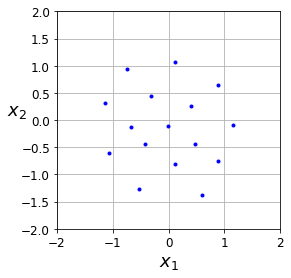

Training Bob in Epoch 1/5
Iteration: 10, Epoch: 1, Loss: -1.65714, Batch_BER: 0.87600
Iteration: 20, Epoch: 1, Loss: -1.63611, Batch_BER: 0.74200
Iteration: 30, Epoch: 1, Loss: -1.61605, Batch_BER: 0.71600
Iteration: 40, Epoch: 1, Loss: -1.59700, Batch_BER: 0.69600
Iteration: 50, Epoch: 1, Loss: -1.57886, Batch_BER: 0.58200
Iteration: 60, Epoch: 1, Loss: -1.56161, Batch_BER: 0.57400
Iteration: 70, Epoch: 1, Loss: -1.54512, Batch_BER: 0.50600
Iteration: 80, Epoch: 1, Loss: -1.52916, Batch_BER: 0.51400
Iteration: 90, Epoch: 1, Loss: -1.51376, Batch_BER: 0.46200
Iteration: 100, Epoch: 1, Loss: -1.49888, Batch_BER: 0.44800
Iteration: 110, Epoch: 1, Loss: -1.48439, Batch_BER: 0.44000
Iteration: 120, Epoch: 1, Loss: -1.47028, Batch_BER: 0.35200
Iteration: 130, Epoch: 1, Loss: -1.45654, Batch_BER: 0.35400
Iteration: 140, Epoch: 1, Loss: -1.44305, Batch_BER: 0.35000
Iteration: 150, Epoch: 1, Loss: -1.42987, Batch_BER: 0.29400
Iteration: 160, Epoch: 1, Loss: -1.41705, Batch_BER: 0.27800
Iterati

Iteration: 130, Epoch: 4, Loss: 1.12973, Batch_BER: 0.27600
Iteration: 140, Epoch: 4, Loss: 1.12993, Batch_BER: 0.24800
Iteration: 150, Epoch: 4, Loss: 1.13071, Batch_BER: 0.26600
Iteration: 160, Epoch: 4, Loss: 1.12968, Batch_BER: 0.29200
Iteration: 170, Epoch: 4, Loss: 1.12850, Batch_BER: 0.24400
Iteration: 180, Epoch: 4, Loss: 1.12649, Batch_BER: 0.26200
Iteration: 190, Epoch: 4, Loss: 1.12542, Batch_BER: 0.25400
Iteration: 200, Epoch: 4, Loss: 1.12466, Batch_BER: 0.24200
Iteration: 210, Epoch: 4, Loss: 1.12782, Batch_BER: 0.24400
Iteration: 220, Epoch: 4, Loss: 1.12695, Batch_BER: 0.21600
Iteration: 230, Epoch: 4, Loss: 1.12563, Batch_BER: 0.25400
Iteration: 240, Epoch: 4, Loss: 1.12611, Batch_BER: 0.24800
Iteration: 250, Epoch: 4, Loss: 1.12603, Batch_BER: 0.22800
Iteration: 260, Epoch: 4, Loss: 1.12426, Batch_BER: 0.24800
Iteration: 270, Epoch: 4, Loss: 1.12552, Batch_BER: 0.24800
Iteration: 280, Epoch: 4, Loss: 1.12667, Batch_BER: 0.25800
Iteration: 290, Epoch: 4, Loss: 1.12524,

In [19]:
score_fn = NN_function(**critic_params)
train_mi(score_fn, n_epochs=1, n_steps=500, batch_size=64)
train_encoder(score_fn, n_epochs=5, n_steps=400, batch_size=64, learning_rate=0.005)
test_encoding(M, 1)
train_decoder(n_epochs=5, n_steps=400, batch_size=500, learning_rate=0.005, plot_encoding=False)

In [20]:
bber_data = Test_AE()

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


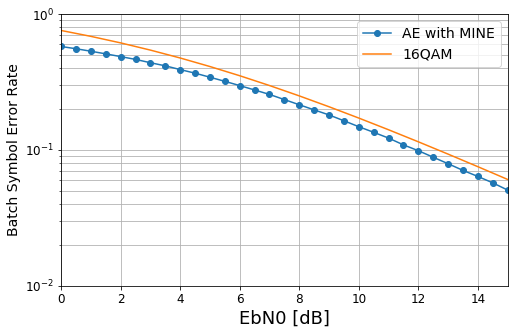

In [21]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

def MQAM_rayleigh_approx(M, ebnodb):
    ebno = 10.**(ebnodb/10)
    esno = 4*ebno
    #Goldsmith, p.185, 6.3.2, Eqn 6.61, alphaM=4, betaM=3/(M-1)
    a=3.25 #adjusted mean number of neighbors
    b=3/(M-1)
    e=b*esno
    return (a/2)*(1-np.sqrt(0.5*e / (1+0.5*e) ) ), a/(2*b*esno)

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(bber_data[0], bber_data[1], 'o-')

a, b = MQAM_rayleigh_approx(16,ebnodbs)
plt.plot(ebnodbs, a);
#plt.semilogy(ebnodbs, MQAM_rayleigh_approx(M, ebnodbs), '^-');
plt.gca().set_ylim(1e-2, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("EbN0 [dB]", fontsize=18)
plt.legend(['AE with MINE', '16QAM'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")